from google.colab import drive
drive.mount('/content/drive')

In [438]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
import time
from datetime import datetime
import math
from statistics import median

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#Loading the dataset and looking at the data types in the dataset
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Mojo_budget_update.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3243 non-null   object 
 1   title            3243 non-null   object 
 2   year             3243 non-null   int64  
 3   trivia           3243 non-null   object 
 4   mpaa             3082 non-null   object 
 5   release_date     3242 non-null   object 
 6   run_time         3243 non-null   object 
 7   distributor      3228 non-null   object 
 8   director         3243 non-null   object 
 9   writer           3234 non-null   object 
 10  producer         3230 non-null   object 
 11  composer         3138 non-null   object 
 12  cinematographer  3129 non-null   object 
 13  main_actor_1     3243 non-null   object 
 14  main_actor_2     3243 non-null   object 
 15  main_actor_3     3243 non-null   object 
 16  main_actor_4     3240 non-null   object 
 17  budget        

In [439]:
#Looking at the first 3 rows of the dataset
movies.head(3)

,movie_id,title,year,trivia,mpaa,release_date,run_time,distributor,director,writer,producer,composer,cinematographer,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html
0,tt0099088,Back to the Future Part III,1990,"Stranded in 1955, Marty McFly learns about the...",NaN,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Robert Zemeckis,Neil Canton,Alan Silvestri,Dean Cundey,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,88277583.0,157866667.0,246144250.0,Adventure,Comedy,Sci-Fi,Western,https://www.boxofficemojo.com/title/tt0099088/...
1,tt0099165,The Bonfire of the Vanities,1990,"After his mistress runs over a young teen, a W...",R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Michael Cristofer,Brian De Palma,Dave Grusin,Vilmos Zsigmond,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,NaN,15691192.0,Comedy,Drama,Romance,NaN,https://www.boxofficemojo.com/title/tt0099165/...
2,tt0099348,Dances with Wolves,1990,"Lieutenant John Dunbar, assigned to a remote w...",NaN,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Michael Blake,Kevin Costner,John Barry,Dean Semler,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,184208848.0,240000000.0,424208848.0,Adventure,Drama,Western,NaN,https://www.boxofficemojo.com/title/tt0099348/...


####**Date Cleaning & EDA**

In [440]:
#Checking for duplicates
print('Number of duplicate Movie_ID: {}'.format(movies['movie_id'].duplicated().sum()))

Number of duplicate Movie_ID: 0


In [441]:
# Checking for null values and their percentage
num_null_values = movies.isnull().sum()
print(num_null_values)
print('----------------------------')
percentage = num_null_values / len(movies)
print(percentage)

movie_id              0
title                 0
year                  0
trivia                0
mpaa                161
release_date          1
run_time              0
distributor          15
director              0
writer                9
producer             13
composer            105
cinematographer     114
main_actor_1          0
main_actor_2          0
main_actor_3          0
main_actor_4          3
budget                0
domestic             19
international       410
worldwide             7
genre_1               0
genre_2             281
genre_3            1022
genre_4            2120
html                  0
dtype: int64
----------------------------
movie_id           0.000000
title              0.000000
year               0.000000
trivia             0.000000
mpaa               0.049645
release_date       0.000308
run_time           0.000000
distributor        0.004625
director           0.000000
writer             0.002775
producer           0.004009
composer           0.03237

In [442]:
#Since there is very few null values for worldwide & distributor, then I will remove these rows and create a new dataframe

moviesNew = movies.dropna(subset=['worldwide', 'distributor'])
num_null_values = moviesNew.isnull().sum()
num_null_values

movie_id              0
title                 0
year                  0
trivia                0
mpaa                156
release_date          0
run_time              0
distributor           0
director              0
writer                9
producer             12
composer            105
cinematographer     114
main_actor_1          0
main_actor_2          0
main_actor_3          0
main_actor_4          3
budget                0
domestic             12
international       403
worldwide             0
genre_1               0
genre_2             271
genre_3            1008
genre_4            2101
html                  0
dtype: int64

In [443]:
#Let us replace the NaN in the domestic and international with 0

moviesNew['domestic'] = moviesNew['domestic'].fillna(0)
moviesNew['international'] = moviesNew['international'].fillna(0)
num_null_values = moviesNew.isnull().sum()
num_null_values

movie_id              0
title                 0
year                  0
trivia                0
mpaa                156
release_date          0
run_time              0
distributor           0
director              0
writer                9
producer             12
composer            105
cinematographer     114
main_actor_1          0
main_actor_2          0
main_actor_3          0
main_actor_4          3
budget                0
domestic              0
international         0
worldwide             0
genre_1               0
genre_2             271
genre_3            1008
genre_4            2101
html                  0
dtype: int64

In [444]:
#I will then replace the NaN in the mpaa with the most common PG-13

print(moviesNew['mpaa'].value_counts().head())        #Printing the MPAA counts before replacement
moviesNew['mpaa'] = moviesNew['mpaa'].fillna('PG-13')
print('----------------------------------')
print(moviesNew['mpaa'].value_counts().head())        #Printing the MPAA counts after replacement

R        1340
PG-13    1221
PG        476
G          22
NC-17       6
Name: mpaa, dtype: int64
----------------------------------
PG-13    1377
R        1340
PG        476
G          22
NC-17       6
Name: mpaa, dtype: int64


In [445]:
#### I can delete the following columns as they are irrelvant to my analysis
#### writer, producer, composer, cinematographer & html as well as domestic & international as I am predicting Wordlwide Revenue

moviesNew.drop(['trivia','writer','producer','composer', 'cinematographer', 'html', 'domestic', 'international'], axis='columns', inplace=True)
moviesNew.head(3)

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,worldwide,genre_1,genre_2,genre_3,genre_4
0,tt0099088,Back to the Future Part III,1990,PG-13,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,Sci-Fi,Western
1,tt0099165,The Bonfire of the Vanities,1990,R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,Romance,NaN
2,tt0099348,Dances with Wolves,1990,PG-13,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,424208848.0,Adventure,Drama,Western,NaN


In [446]:
# Since there is only 3 missing names under main_actor_4, then I can fill them with 'No Actor'

moviesNew['main_actor_4'] = moviesNew['main_actor_4'].fillna('No Actor')
moviesNew[moviesNew['main_actor_4'] == 'No Actor']

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,worldwide,genre_1,genre_2,genre_3,genre_4
2769,tt2276023,The United States of Autism,2013,PG-13,April 5,1 hr 33 min,Janson Media,Richard Everts,Kenneth Bock,Richard Everts,Raun Kaufman,No Actor,65000.0,100403.0,Biography,Documentary,Family,News
2812,tt2401878,Anomalisa,2015,R,December 30,1 hr 30 min,Paramount Pictures,Duke Johnson,David Thewlis,Jennifer Jason Leigh,Tom Noonan,No Actor,8000000.0,5659286.0,Animation,Comedy,Drama,Romance
3026,tt4218572,Widows,2018,R,November 9,2 hr 9 min,Twentieth Century Fox,Steve McQueen,Viola Davis,Michelle Rodriguez,Elizabeth Debicki,No Actor,42000000.0,75984700.0,Crime,Drama,Thriller,NaN


In [447]:
#Renaming some columns to improve the readability of the dataset 

#pd.set_option('display.float_format', '${0:,.2f}'.format)
moviesNew = moviesNew.rename(columns={"domestic": "Domestic_Revenue", "international": "International_Revenue", "worldwide": "Worldwide_Revenue"})
moviesNew.head(3)

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,genre_3,genre_4
0,tt0099088,Back to the Future Part III,1990,PG-13,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,Sci-Fi,Western
1,tt0099165,The Bonfire of the Vanities,1990,R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,Romance,NaN
2,tt0099348,Dances with Wolves,1990,PG-13,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,424208848.0,Adventure,Drama,Western,NaN


In [448]:
moviesNew.describe()

# Some findings:
# 1. The average Worldwide Revenue is $139,757,500
# 2. The highest Worldwide Revenue is $2,797,801,000
# 3. The average Budget is $46,396,300
# 4. The highest Budget is $356,000,000 
# 5. The movies in the dataset are between the year 1990 and 2020

,year,budget,Worldwide_Revenue
count,3221.000000,3.221000e+03,3.221000e+03
mean,2006.656007,4.639630e+07,1.397575e+08
std,7.221364,4.714060e+07,2.165638e+08
min,1990.000000,2.200000e+02,3.000000e+01
25%,2001.000000,1.400000e+07,1.912640e+07
50%,2007.000000,3.000000e+07,6.267510e+07
75%,2012.000000,6.200000e+07,1.698528e+08
max,2020.000000,3.560000e+08,2.797801e+09


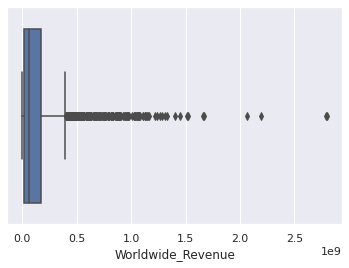

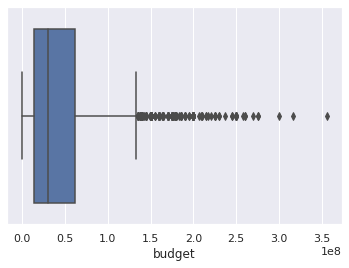

In [449]:
sns.boxplot(x=moviesNew['Worldwide_Revenue'])
plt.show()
sns.boxplot(x=moviesNew['budget'])
plt.show()

In [450]:
# 6. The lowest Worldwide Revenue is $30, which is very low, so let us investigate more and look at the lowest 10 Grossing movies
cols = ['movie_id', 'title', 'year', 'Worldwide_Revenue']
lowestRev = moviesNew.sort_values('Worldwide_Revenue', ascending=True)[cols].set_index('movie_id')
lowestRev.head(10)

,title,year,Worldwide_Revenue
movie_id,,,
tt0429277,Zyzzyx Rd,2006,30.0
tt1019449,The Rise and Fall of Miss Thang,2007,581.0
tt1235168,Redneck Carnage,2009,706.0
tt0431155,Issues,2005,783.0
tt0387057,Beat the Drum,2003,895.0
tt0102032,High Strung,1992,904.0
tt1735485,The Tunnel,2011,1532.0
tt0396587,FAQs,2005,1967.0
tt2382420,Split: A Deeper Divide,2012,2000.0


In [451]:
# Findings from the above table
# 1. The first movie title dosen't seem correct, so we can delete this record
# 2. After searching the 'www.the-numbers.com' for the rest of the above list:
#   a. The following movies doesn't exist: 'Redneck Carnage', 'Beat the Drum', 'High Strung from 1992', 'The Tunnel from 2011'
#   b. 'The Velocity of Gary' movie has an incorrect Worldwide Revenue
# 3. So to fix these problems, I chose to delete all records that has Worldwide Revenue less than $100,000

# Get indexes where Revenue column is less than $100,000
indexRev = moviesNew[ moviesNew['Worldwide_Revenue'] < 100000 ].index

# Delete these row indexes from the dataframe

moviesNew.drop(indexRev, inplace=True)

cols = ['movie_id', 'title', 'year', 'Worldwide_Revenue', 'budget']
lowestRev = moviesNew.sort_values('Worldwide_Revenue', ascending=True)[cols].set_index('movie_id')
lowestRev.head(10)

,title,year,Worldwide_Revenue,budget
movie_id,,,,
tt2276023,The United States of Autism,2013,100403.0,65000.0
tt1247662,The Good Guy,2009,100688.0,10000000.0
tt0478262,Return with Honor: A Missionary Homecoming,2006,102171.0,300000.0
tt0262911,World Traveler,2001,103863.0,2000000.0
tt0119506,Lawn Dogs,1997,106404.0,8000000.0
tt1210039,Blood Done Sign My Name,2010,109383.0,10000000.0
tt0102898,Shakes the Clown,1991,115103.0,1400000.0
tt0156096,Spring Forward,1999,117471.0,2000000.0
tt1161418,Gentlemen Broncos,2009,118492.0,10000000.0


In [452]:
moviesNew.describe(include='object')

# Some findings regarding from the table below
# 1. MPAA: There are 5 different movies rating, with the most frequent one is PG-13
# 2. Ditributor: There are 157 different production companies, Warner Bros. is the top with 388 movies
# 3. Main Actor 1: Adam Sandler top the list with 27 movies
# 4. Main Actor 2: Samuel L. Jackson top this list with 15 movies
# 5. The most frequent Genres are 'Action' and 'Drama'

,movie_id,title,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,genre_1,genre_2,genre_3,genre_4
count,3151,3151,3151,3151,3151,3151,3151,3151,3151,3151,3151,3151,2906,2188,1116
unique,3151,3125,5,365,121,157,1455,1238,1663,2056,2340,15,20,20,17
top,tt1270286,Robin Hood,PG-13,December 25,1 hr 41 min,Warner Bros.,Clint Eastwood,Adam Sandler,Samuel L. Jackson,Morgan Freeman,Amanda Peet,Action,Drama,Thriller,Thriller
freq,1,2,1343,48,93,388,20,27,15,11,7,918,747,382,356


In [453]:
# I will drop the genre_3 and genre_4 columns as they have more than 30% missing values.

moviesNew.drop(['genre_3', 'genre_4'], axis='columns', inplace=True)

In [454]:
# Replace NaN in genre_2 with 'No Secondary Genre'

moviesNew['genre_2'] = moviesNew['genre_2'].fillna('No Secondary Genre')
moviesNew[moviesNew['genre_2'] == 'No Secondary Genre'].head(5)

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2
15,tt0100332,Paris Is Burning,1990,R,August 9,1 hr 11 min,Miramax,Jennie Livingston,Brooke Xtravaganza,André Christian,Dorian Corey,Paris Duprée,500000.0,3905297.0,Documentary,No Secondary Genre
24,tt0101587,City Slickers,1991,PG-13,June 7,1 hr 53 min,Columbia Pictures,Ron Underwood,Billy Crystal,Jack Palance,Daniel Stern,Bruno Kirby,27000000.0,179033791.0,Comedy,No Secondary Genre
39,tt0102303,Life Stinks,1991,PG-13,July 26,1 hr 32 min,Metro-Goldwyn-Mayer MGM,Mel Brooks,Mel Brooks,Lesley Ann Warren,Jeffrey Tambor,Stuart Pankin,13000000.0,4102526.0,Comedy,No Secondary Genre
47,tt0102558,Nothing But Trouble,1991,PG-13,February 15,1 hr 34 min,Warner Bros.,Dan Aykroyd,Chevy Chase,Dan Aykroyd,John Candy,Demi Moore,40000000.0,8479793.0,Comedy,No Secondary Genre
49,tt0102753,Rambling Rose,1991,R,September 20,1 hr 52 min,New Line Cinema,Martha Coolidge,Laura Dern,Robert Duvall,Diane Ladd,Lukas Haas,7500000.0,6266621.0,Drama,No Secondary Genre


####**Revenue & Budget**

In [455]:
#Let us look at the Top 20 movies based on Worldwide Revenue with release year

cols = ['title', 'Worldwide_Revenue', 'year']
revenueData = moviesNew.sort_values('Worldwide_Revenue', ascending=False)[cols].set_index('title')
top_20_revenue = revenueData.head(20)

fig = px.bar(top_20_revenue, x=top_20_revenue.index, y='Worldwide_Revenue', text='year', title = 'Top 20 Revenue Movies', color = 'Worldwide_Revenue', height=700, width=1200, 
             labels={'Worldwide_Revenue':'Global Revenue in USD Billion',  'x':''})
fig.update_traces(textposition = 'outside')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

# Avengers:Endgame which was released in 2019 recorded the highest Global Revenue in the last 30 years

In [456]:
#Let us look at the Top 20 movies based on Budget with year of release

cols = ['title', 'budget', 'year']
budgetData = moviesNew.sort_values('budget', ascending=False)[cols].set_index('title')
top_20_budget = budgetData.head(20)

fig = px.bar(top_20_budget, x=top_20_budget.index, y='budget', text='year', title = 'Top 20 Budget Movies', color = 'budget', height=700, width=1200, 
             labels={'budget':'Budget in USD Million', 'x':''})
fig.update_traces(textposition = 'outside')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

# Avengers:Endgame which was released in 2019 had the highest production cost in the last 30 years

In [457]:
#Let us look at the Top 10 profitable movies

profitsValue = moviesNew['Worldwide_Revenue'] - moviesNew['budget']
profitsValue.name = 'profit'
profitsData = moviesNew.join(profitsValue)[['title', 'budget', 'Worldwide_Revenue', 'profit']].sort_values('profit', ascending=False)
top_10_profits = profitsData.head(10).set_index('title')

fig = go.Figure()
fig.add_trace(go.Bar(
    x=top_10_profits.index,
    y=profitsData.Worldwide_Revenue,
    name='Global Revenue',
    marker_color='orange'
))
fig.add_trace(go.Bar(
    x=top_10_profits.index,
    y=profitsData.budget,
    name='Budget',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=top_10_profits.index,
    y=profitsData.profit,
    name='Profit',
    marker_color='purple'
))

fig.update_layout(
    title = 'Top 10 Profitable Movies'
    )
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

# Avatar recorded the highest profitable movie with over $2.5 USD Billion 

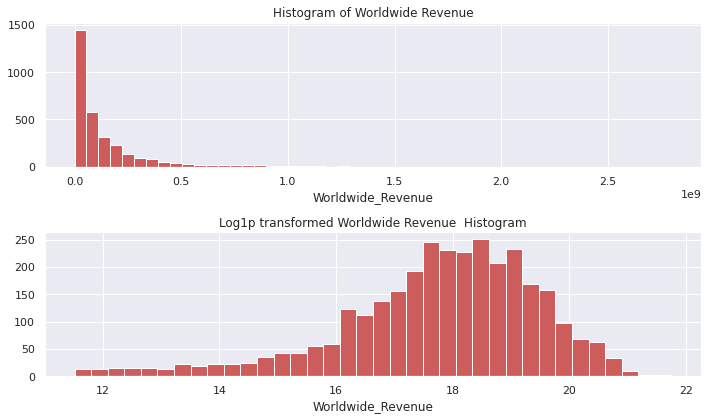

In [458]:
## Exploring the Target (Dependent) variable - Worldwide Revenue

f, ax = plt.subplots(2, figsize=(10,6))
sns.set(rc={'figure.figsize':(12,8)})

sns.distplot(a=moviesNew.Worldwide_Revenue, kde = False, ax = ax[0], color='indianred', hist_kws=dict(alpha=1))
ax[0].set_title("Histogram of Worldwide Revenue")
sns.distplot(a=np.log1p(moviesNew.Worldwide_Revenue), kde = False, ax = ax[1], color='indianred', hist_kws=dict(alpha=1))
ax[1].set_title("Log1p transformed Worldwide Revenue  Histogram")
f.tight_layout()

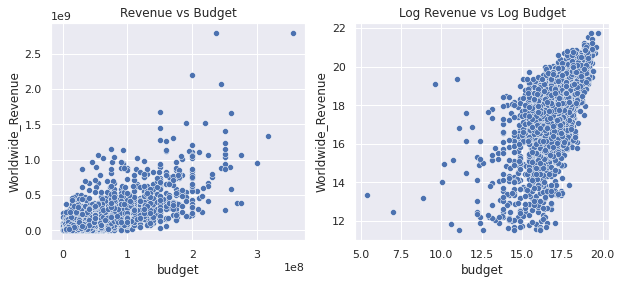

In [459]:
#Relationship between Revenue and Budget

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(moviesNew['budget'], moviesNew['Worldwide_Revenue'])
plt.title('Revenue vs Budget');

#Relationship using the log transformation to make the data look more normal
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(moviesNew['budget']), np.log1p(moviesNew['Worldwide_Revenue']))
plt.title('Log Revenue vs Log Budget');

In [460]:
#Adding the Log Worldwide revenue and Log budget to the DataFrame

moviesNew['Log_Worldwide_Revenue'] = np.log1p(moviesNew['Worldwide_Revenue'])
moviesNew['Log_budget'] = np.log1p(moviesNew['budget'])
moviesNew.head(3)

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,Log_Worldwide_Revenue,Log_budget
0,tt0099088,Back to the Future Part III,1990,PG-13,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,19.321428,17.504390
1,tt0099165,The Bonfire of the Vanities,1990,R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,16.568610,17.665658
2,tt0099348,Dances with Wolves,1990,PG-13,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,424208848.0,Adventure,Drama,19.865736,16.906553


In [461]:
#Correleation between Revenue and Budget

moviesNew[['Log_Worldwide_Revenue', 'Log_budget']].corr()

## There is a Strong Positive relationship between Budget and Worldwide Revenue

,Log_Worldwide_Revenue,Log_budget
Log_Worldwide_Revenue,1.00000,0.66538
Log_budget,0.66538,1.00000


In [462]:
## Creating a subset DataFrame for Budget and Revenue
budget_df = moviesNew[['movie_id', 'Log_Worldwide_Revenue', 'Log_budget']]

In [463]:
## Splitting the data into Traain and Test
from sklearn.model_selection import train_test_split

x = budget_df.drop(['Log_Worldwide_Revenue', 'movie_id'], axis=1)
y = budget_df['Log_Worldwide_Revenue']
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state=1, test_size=0.20)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (2520, 1) (2520,)
Test set:  (631, 1) (631,)


In [464]:
## Creating Linear regression model and testing results

from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

lm = LinearRegression()
lm.fit(X_train, y_train)
lm_prediction = lm.predict(X_test)

run_time=time.time()

results = {'Model':['Linear Regression'],
           'Dependent Var':['Budget'],
           'R-Square':[metrics.r2_score(y_test, lm_prediction)],
           'MSE':[metrics.mean_squared_error(y_test, lm_prediction)],
           'RMSE':[np.sqrt(metrics.mean_squared_error(y_test, lm_prediction))],
           'Run Time':[round(((time.time()-run_time)/60),2)]}
results_df = pd.DataFrame(results)

In [465]:
## Creating LightGBM model and testing results

import lightgbm as lgb

model_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="mse", 
                             min_child_samples=100,
                             use_best_model=True)

In [466]:
model_lgb.fit(X_train.values,y_train)

lgb_pred_train=model_lgb.predict(X_test.values)
#run_time=time.time()

results1 = {'Model':'LGBMReg','Dependent Var':'Budget', 'R-Square':metrics.r2_score(y_test, lgb_pred_train), 'MSE':metrics.mean_squared_error(y_test, lgb_pred_train),
            'RMSE':np.sqrt(metrics.mean_squared_error(y_test, lgb_pred_train)),'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results1, ignore_index=True)

In [467]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rf_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)

rf_model=rf_model.predict(X_test.values)
#run_time=time.time()

results2 = {'Model':'RandomForest','Dependent Var':'Budget', 'R-Square':metrics.r2_score(y_test, rf_model), 'MSE':metrics.mean_squared_error(y_test, rf_model),
            'RMSE':np.sqrt(metrics.mean_squared_error(y_test, rf_model)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results2, ignore_index=True)

####**MAIN** **GENRE**

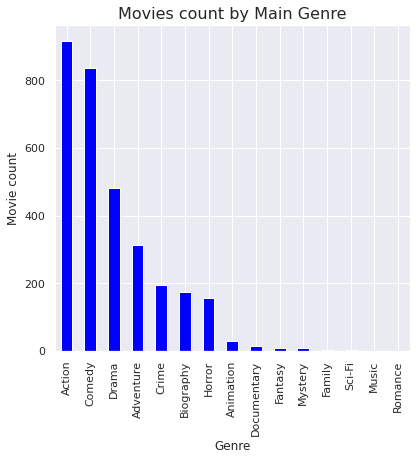

In [468]:
## Checking the movies count per Main Genre

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
moviesNew['genre_1'].value_counts().plot(kind='bar', color='blue');
plt.title('Movies count by Main Genre', size=16)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

## Top movies released was for Genre 'Action', 'Comedy', 'Drama', and 'Adventure

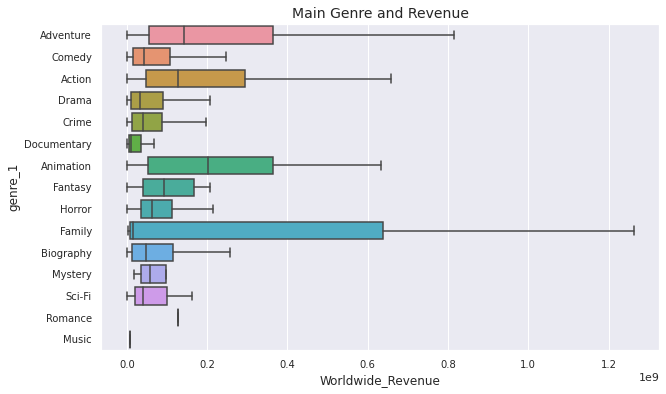

In [469]:
## Looking at Main Genre and Revenue

fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', labelsize=10)
plt.title('Main Genre and Revenue', fontsize=14)
plt.xlabel('Worldwide Revenue', fontsize=12)
plt.ylabel('Main Genre', fontsize=12)
sns.boxplot(ax=ax, x=moviesNew.Worldwide_Revenue, y=moviesNew.genre_1, showfliers=False, orient='h')
plt.show();

## Main genres 'Family, Adventure, Animation and Action' generated the highest worldwide revenue

In [470]:
## Creating a list of the TOP 5 Genre by movies released
genre_mask = ['Action', 'Comedy', 'Drama', 'Adventure', 'Crime']
movies_genre = moviesNew[moviesNew['genre_1'].isin(genre_mask)] 
movies_genre.head(3)    ## Looking at the DataFrame with records has the TOP 5 Genre

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,Log_Worldwide_Revenue,Log_budget
0,tt0099088,Back to the Future Part III,1990,PG-13,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,19.321428,17.504390
1,tt0099165,The Bonfire of the Vanities,1990,R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,16.568610,17.665658
2,tt0099348,Dances with Wolves,1990,PG-13,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,424208848.0,Adventure,Drama,19.865736,16.906553


In [471]:
## Creating dummy variables for Genre
genre_df = movies_genre[['movie_id', 'Log_Worldwide_Revenue', 'Log_budget', 'genre_1']]
genre_df = pd.get_dummies(genre_df, columns=['genre_1'], drop_first=True)
genre_df.head(5)

,movie_id,Log_Worldwide_Revenue,Log_budget,genre_1_Adventure,genre_1_Comedy,genre_1_Crime,genre_1_Drama
0,tt0099088,19.321428,17.504390,1,0,0,0
1,tt0099165,16.568610,17.665658,0,1,0,0
2,tt0099348,19.865736,16.906553,1,0,0,0
3,tt0099422,18.907657,17.665658,0,0,0,0
4,tt0099423,19.297180,18.064006,0,0,0,0


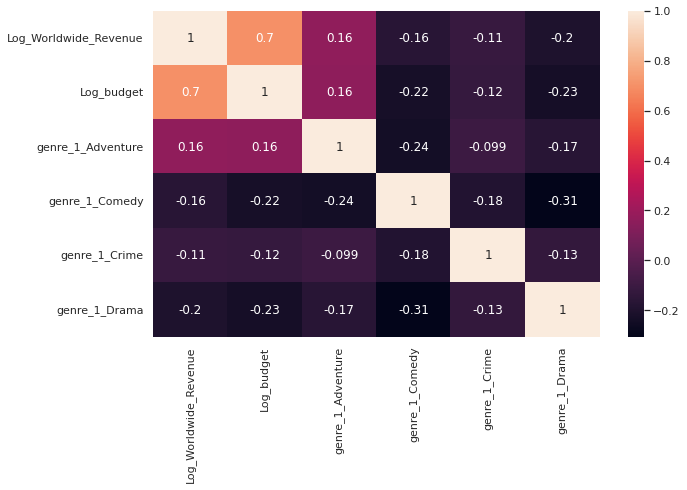

In [472]:
#Relationship between Revenue and Top 5 Genre

corrMatrix_genre = genre_df.corr()
plt.subplots(figsize = (10,6))
sns.heatmap(corrMatrix_genre, annot=True)
plt.show()

## There is a very weak relationship between Main Genre and Worldwide Revenue

In [473]:
from sklearn.model_selection import train_test_split

x1 = genre_df.drop(['Log_Worldwide_Revenue', 'movie_id'], axis=1)
y1 = genre_df['Log_Worldwide_Revenue']
X1_train, X1_test, y1_train, y1_test = train_test_split(x1,y1, random_state=1, test_size=0.20)
print('Train set: ', X1_train.shape, y1_train.shape)
print('Test set: ', X1_test.shape, y1_test.shape)

Train set:  (2196, 5) (2196,)
Test set:  (550, 5) (550,)


In [474]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

lm1 = LinearRegression()
lm1.fit(X1_train, y1_train)
lm1_prediction = lm1.predict(X1_test)
#run_time=time.time()

results3 = {'Model':'Linear Regression','Dependent Var':'Budget & Genre', 'R-Square':metrics.r2_score(y1_test, lm1_prediction), 
            'MSE':metrics.mean_squared_error(y1_test, lm1_prediction),
            'RMSE':np.sqrt(metrics.mean_squared_error(y1_test, lm1_prediction)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results3, ignore_index=True)

In [475]:
model1_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="mse", 
                             min_child_samples=100,
                             use_best_model=True)
model1_lgb.fit(X1_train.values,y1_train)
lgb1_pred_train=model1_lgb.predict(X1_test.values)
#run_time=time.time()

results4 = {'Model':'LGBMReg','Dependent Var':'Budget & Genre', 'R-Square':metrics.r2_score(y1_test, lgb1_pred_train), 
            'MSE':metrics.mean_squared_error(y1_test, lgb1_pred_train),
            'RMSE':np.sqrt(metrics.mean_squared_error(y1_test, lgb1_pred_train)),'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results4, ignore_index=True)

In [476]:

rf1_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
rf1_model.fit(X1_train, y1_train)

rf1_model=rf1_model.predict(X1_test.values)
#run_time=time.time()
results5 = {'Model':'RandomForest','Dependent Var':'Budget & Genre', 'R-Square':metrics.r2_score(y1_test, rf1_model), 
            'MSE':metrics.mean_squared_error(y1_test, rf1_model),
            'RMSE':np.sqrt(metrics.mean_squared_error(y1_test, rf1_model)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results5, ignore_index=True)

####**DISTRIBUTOR**

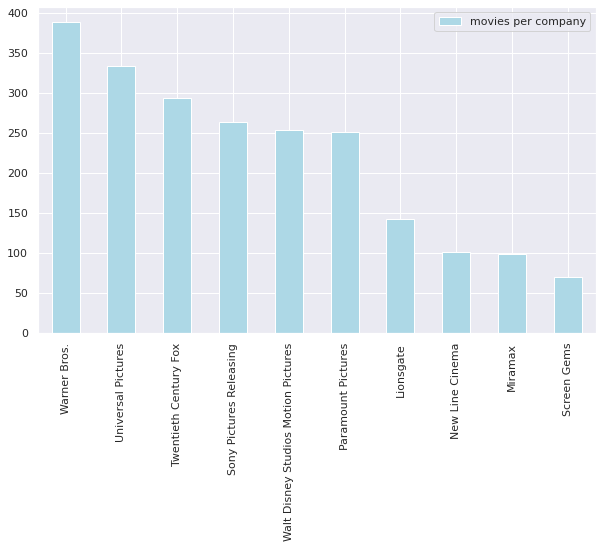

In [477]:
## Looking at the Number of movies per Distributor (TOP 10)

distributorDict = {}
for elem in moviesNew["distributor"].values:
    #for dist in element:
    if elem not in distributorDict:
      distributorDict[elem] = 1
    else:
      distributorDict[elem] += 1

dist_df = pd.DataFrame.from_dict(distributorDict, orient='index', columns=["movies per company"])
dist_df.sort_values(by="movies per company", ascending=False).head(10).plot.bar(color='lightblue', figsize=(10,6))

dist_df.columns = ["num_of_movies"]

# We can see that 'Warner Bros.' has the highest number of movies produced.

In [478]:
## Looking at the Total Revenue per Distributor

## Creating an index for Distributors
dist_df.index.values
for d in dist_df.index.values:
    moviesNew[d] = moviesNew['distributor'].apply(lambda x: 1 if d in x else 0)

## Total Revenue per Distributor
for i, d in enumerate(dist_df.index.values):
    dist_df.loc[d, "total_revenue"] = moviesNew[moviesNew[d]==1].Worldwide_Revenue.sum()

dist_df.sort_values(by=["total_revenue", "num_of_movies"], ascending=False).head(5)

,num_of_movies,total_revenue
Walt Disney Studios Motion Pictures,253,7.487085e+10
Warner Bros.,388,6.761542e+10
Universal Pictures,334,6.083843e+10
Twentieth Century Fox,294,5.987527e+10
Sony Pictures Releasing,263,4.732572e+10


Text(0.5, 0, 'Distributor')

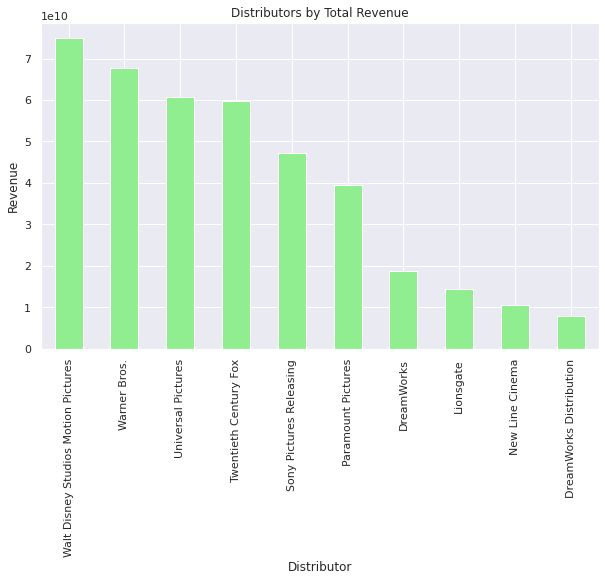

In [479]:
# TOP 10 Distributors by Total Revenue

dist_df.sort_values(by=["total_revenue"], ascending=False).total_revenue.head(10).plot.bar(color='lightgreen', figsize=(10,6))
plt.title("Distributors by Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Distributor")

#'Walt Disney Studios' has the highest total revenue earner

In [480]:
## Will group the TOP 10 distributors and the rest will be OTHER 

top10_dist = moviesNew['distributor'].value_counts()[:10].index
top10_dist

Index(['Warner Bros.', 'Universal Pictures', 'Twentieth Century Fox',
       'Sony Pictures Releasing', 'Walt Disney Studios Motion Pictures',
       'Paramount Pictures', 'Lionsgate', 'New Line Cinema', 'Miramax',
       'Screen Gems'],
      dtype='object')

In [481]:
## Creating a subset DataFrame for TOP 10 Distributors

dist_df = moviesNew[moviesNew['distributor'].isin(top10_dist)]
dist_df = dist_df[['movie_id', 'Log_Worldwide_Revenue', 'Log_budget', 'distributor']]
dist_df.head(3)

,movie_id,Log_Worldwide_Revenue,Log_budget,distributor
0,tt0099088,19.321428,17.504390,Universal Pictures
1,tt0099165,16.568610,17.665658,Warner Bros.
3,tt0099422,18.907657,17.665658,Walt Disney Studios Motion Pictures


In [482]:
## Creating dummys for TOP 10 Distributors

dist_df = pd.get_dummies(dist_df, columns=['distributor'], drop_first=True)
dist_df.head(5)

,movie_id,Log_Worldwide_Revenue,Log_budget,distributor_Miramax,distributor_New Line Cinema,distributor_Paramount Pictures,distributor_Screen Gems,distributor_Sony Pictures Releasing,distributor_Twentieth Century Fox,distributor_Universal Pictures,distributor_Walt Disney Studios Motion Pictures,distributor_Warner Bros.
0,tt0099088,19.321428,17.504390,0,0,0,0,0,0,1,0,0
1,tt0099165,16.568610,17.665658,0,0,0,0,0,0,0,0,1
3,tt0099422,18.907657,17.665658,0,0,0,0,0,0,0,1,0
4,tt0099423,19.297180,18.064006,0,0,0,0,0,1,0,0,0
5,tt0099587,16.495692,17.370859,0,0,1,0,0,0,0,0,0


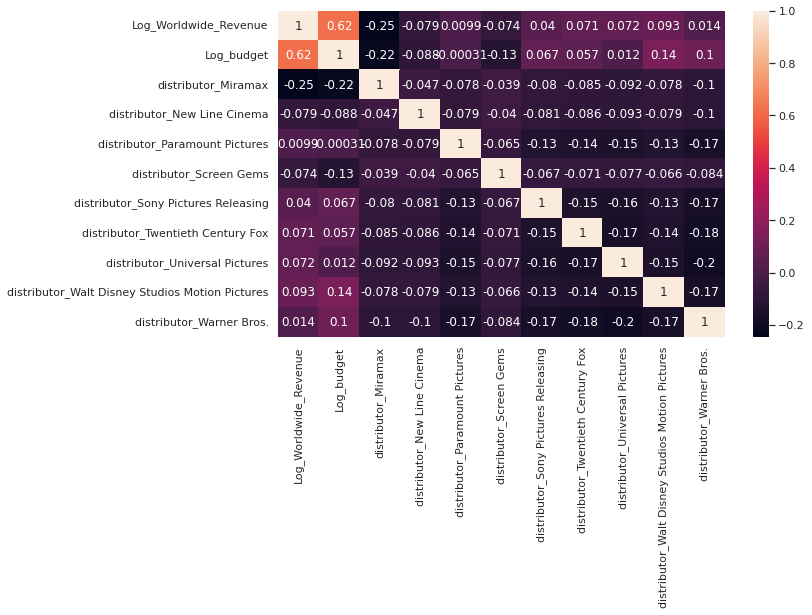

In [483]:
## Correlation between Revenue and TOP 10 Distributor

corrMatrix_dist = dist_df.corr()
plt.subplots(figsize = (10,6))
sns.heatmap(corrMatrix_dist, annot=True)
plt.show()

## Also there is a very little correlation between Distributor and Worldwide Revenue

In [484]:
x2 = dist_df.drop(['Log_Worldwide_Revenue', 'movie_id'], axis=1)
y2 = dist_df['Log_Worldwide_Revenue']
X2_train, X2_test, y2_train, y2_test = train_test_split(x2,y2, random_state=1, test_size=0.20)
print('Train set: ', X2_train.shape, y2_train.shape)
print('Test set: ', X2_test.shape, y2_test.shape)

Train set:  (1755, 10) (1755,)
Test set:  (439, 10) (439,)


In [485]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
lm2_prediction = lm2.predict(X2_test)
#run_time=time.time()
results6 = {'Model':'Linear Regression','Dependent Var':'Budget & Distributor', 'R-Square':metrics.r2_score(y2_test, lm2_prediction), 
            'MSE':metrics.mean_squared_error(y2_test, lm2_prediction),
            'RMSE':np.sqrt(metrics.mean_squared_error(y2_test, lm2_prediction)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results6, ignore_index=True)

In [486]:
model2_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="mse", 
                             min_child_samples=100,
                             use_best_model=True)
model2_lgb.fit(X2_train.values,y2_train)
lgb2_pred_train=model2_lgb.predict(X2_test.values)
#run_time=time.time()
results7 = {'Model':'LGBMReg','Dependent Var':'Budget & Distributor', 'R-Square':metrics.r2_score(y2_test, lgb2_pred_train), 
            'MSE':metrics.mean_squared_error(y2_test, lgb2_pred_train),
            'RMSE':np.sqrt(metrics.mean_squared_error(y2_test, lgb2_pred_train)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results7, ignore_index=True)

In [487]:
rf2_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
rf2_model.fit(X2_train, y2_train)

rf2_model=rf2_model.predict(X2_test.values)
#run_time=time.time()
results8 = {'Model':'RandomForest','Dependent Var':'Budget & Distributor', 'R-Square':metrics.r2_score(y2_test, rf2_model), 
            'MSE':metrics.mean_squared_error(y2_test, rf2_model),
            'RMSE':np.sqrt(metrics.mean_squared_error(y2_test, rf2_model)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results8, ignore_index=True)

####**DIRECTOR**

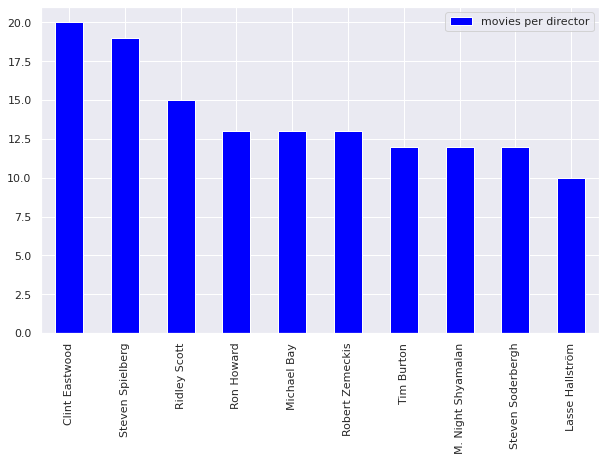

In [488]:
## Looking at the Top 10 director by the number of movies

directorDict = {}
for elem in moviesNew["director"].values:
    if elem not in directorDict:
      directorDict[elem] = 1
    else:
      directorDict[elem] += 1

director_df = pd.DataFrame.from_dict(directorDict, orient='index', columns=["movies per director"])
director_df.sort_values(by="movies per director", ascending=False).head(10).plot.bar(color='Blue', figsize=(10,6))

director_df.columns = ["num_of_movies"]

## The most popular director based on the number of titles is Clint Eastwood

In [489]:
## Creating an index for Directors

director_df.index.values
for d in director_df.index.values:
    moviesNew[d] = moviesNew['director'].apply(lambda x: 1 if d in x else 0)

## Total Revenue per Director
for i, d in enumerate(director_df.index.values):
    director_df.loc[d, "total_revenue"] = moviesNew[moviesNew[d]==1].Worldwide_Revenue.sum()

director_df.sort_values(by=["total_revenue", "num_of_movies"], ascending=False).head(10)

,num_of_movies,total_revenue
Steven Spielberg,19,7.067664e+09
Michael Bay,13,6.451693e+09
James Cameron,4,5.884646e+09
Anthony Russo,4,4.796147e+09
Christopher Nolan,9,4.756854e+09
J.J. Abrams,6,4.653989e+09
Jon Favreau,7,4.294367e+09
Roland Emmerich,10,3.761203e+09
Gore Verbinski,10,3.753025e+09
Bryan Singer,9,3.711342e+09


Text(0.5, 0, 'Director')

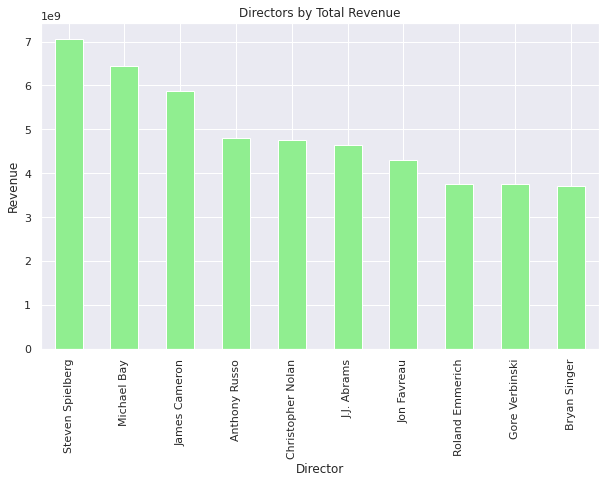

In [490]:
## Directors by Total Revenue

director_df.sort_values(by=["total_revenue"], ascending=False).total_revenue.head(10).plot.bar(color='lightgreen', figsize=(10,6))
plt.title("Directors by Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Director")

## The top director based on the total revenue earned is Steven Spielberg with a total of $7,067,664,000

In [491]:
## Will group the TOP 10 directors and the rest will be OTHER 

top10_direct = moviesNew['director'].value_counts()[:10].index
top10_direct

Index(['Clint Eastwood', 'Steven Spielberg', 'Ridley Scott', 'Ron Howard',
       'Michael Bay', 'Robert Zemeckis', 'M. Night Shyamalan', 'Tim Burton',
       'Steven Soderbergh', 'Peter Berg'],
      dtype='object')

In [492]:
## Creating a subset DataFrame for TOP 10 Directors

director_df = moviesNew[moviesNew['director'].isin(top10_direct)]
director_df = director_df[['movie_id', 'Log_Worldwide_Revenue', 'Log_budget', 'director']]
director_df.head(3)

,movie_id,Log_Worldwide_Revenue,Log_budget,director
0,tt0099088,19.321428,17.504390,Robert Zemeckis
34,tt0102057,19.522138,18.064006,Steven Spielberg
62,tt0103074,17.631789,16.618871,Ridley Scott


In [493]:
## Creating dummys for the TOP 10 Directors

director_df = pd.get_dummies(director_df, columns=['director'], drop_first=True)
director_df.head(3)

,movie_id,Log_Worldwide_Revenue,Log_budget,director_M. Night Shyamalan,director_Michael Bay,director_Peter Berg,director_Ridley Scott,director_Robert Zemeckis,director_Ron Howard,director_Steven Soderbergh,director_Steven Spielberg,director_Tim Burton
0,tt0099088,19.321428,17.504390,0,0,0,0,1,0,0,0,0
34,tt0102057,19.522138,18.064006,0,0,0,0,0,0,0,1,0
62,tt0103074,17.631789,16.618871,0,0,0,1,0,0,0,0,0


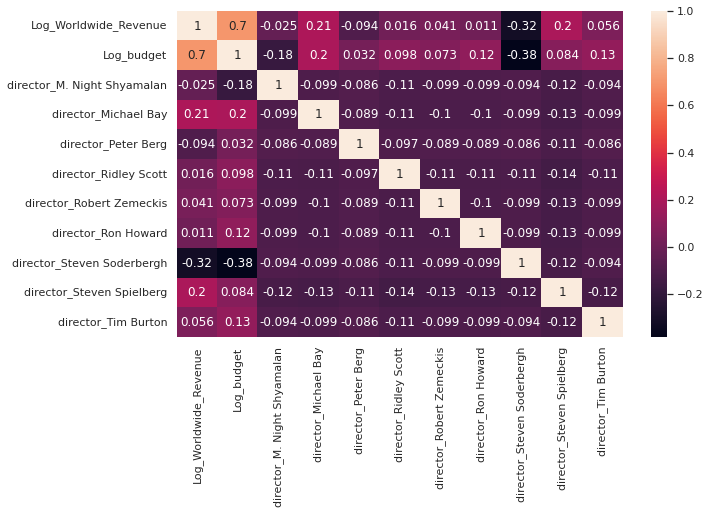

In [494]:
#Relationship between Revenue and TOP 10 Directors

corrMatrix_direct = director_df.corr()
plt.subplots(figsize = (10,6))
sns.heatmap(corrMatrix_direct, annot=True)
plt.show()

## There is a very weak correlation between Director and Worldwide Revenue

In [495]:
x3 = director_df.drop(['Log_Worldwide_Revenue', 'movie_id'], axis=1)
y3 = director_df['Log_Worldwide_Revenue']
X3_train, X3_test, y3_train, y3_test = train_test_split(x3,y3, random_state=1, test_size=0.20)
print('Train set: ', X3_train.shape, y3_train.shape)
print('Test set: ', X3_test.shape, y3_test.shape)

Train set:  (111, 10) (111,)
Test set:  (28, 10) (28,)


In [496]:
lm3 = LinearRegression()
lm3.fit(X3_train, y3_train)
lm3_prediction = lm3.predict(X3_test)
#run_time=time.time()
results9 = {'Model':'Linear Regression','Dependent Var':'Budget & Director', 'R-Square':metrics.r2_score(y3_test, lm3_prediction), 
            'MSE':metrics.mean_squared_error(y3_test, lm3_prediction),
            'RMSE':np.sqrt(metrics.mean_squared_error(y3_test, lm3_prediction)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results9, ignore_index=True)

In [497]:
model3_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="mse", 
                             min_child_samples=100,
                             use_best_model=True)
model3_lgb.fit(X3_train.values,y3_train)
lgb3_pred_train=model3_lgb.predict(X3_test.values)
#run_time=time.time()
results_10 = {'Model':'LGBMReg','Dependent Var':'Budget & Director', 'R-Square':metrics.r2_score(y3_test, lgb3_pred_train), 
            'MSE':metrics.mean_squared_error(y3_test, lgb3_pred_train),
            'RMSE':np.sqrt(metrics.mean_squared_error(y3_test, lgb3_pred_train)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_10, ignore_index=True)

In [498]:
rf3_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
rf3_model.fit(X3_train, y3_train)

rf3_model=rf3_model.predict(X3_test.values)
#run_time=time.time()
results_11 = {'Model':'RandomForest','Dependent Var':'Budget & Director', 'R-Square':metrics.r2_score(y3_test, rf3_model), 
            'MSE':metrics.mean_squared_error(y3_test, rf3_model),
            'RMSE':np.sqrt(metrics.mean_squared_error(y3_test, rf3_model)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_11, ignore_index=True)

####**MAIN ACTOR**

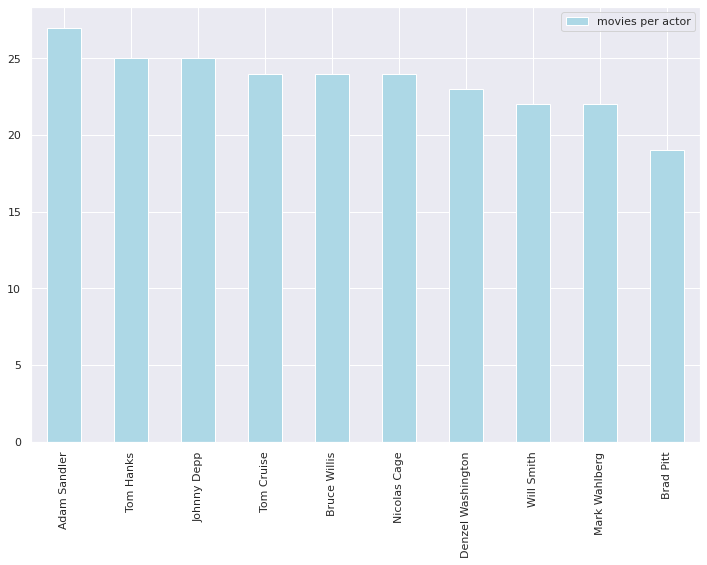

In [499]:
## Looking at the Top 10 Main Actor by the number of movies

actorDict = {}
for elem in moviesNew["main_actor_1"].values:
    if elem not in actorDict:
      actorDict[elem] = 1
    else:
      actorDict[elem] += 1

actor_df = pd.DataFrame.from_dict(actorDict, orient='index', columns=["movies per actor"])
actor_df.sort_values(by="movies per actor", ascending=False).head(10).plot.bar(color = 'lightblue', figsize=(12,8))

actor_df.columns = ["num_of_movies"]

# We can see that the most popular actor based on the number of titles is Adam Sandler

In [500]:
## Looking at TOP 10 Main Actor by Worlwide Revenue

## Creating an index for Actors
actor_df.index.values
for d in actor_df.index.values:
    moviesNew[d] = moviesNew['main_actor_1'].apply(lambda x: 1 if d in x else 0)

## Total Revenue per Actor
for i, d in enumerate(actor_df.index.values):
    actor_df.loc[d, "total_revenue"] = moviesNew[moviesNew[d]==1].Worldwide_Revenue.sum()

actor_df.sort_values(by=["total_revenue", "num_of_movies"], ascending=False).head(10)

,num_of_movies,total_revenue
Robert Downey Jr.,12,9.206894e+09
Tom Hanks,25,8.491896e+09
Tom Cruise,24,8.125249e+09
Will Smith,22,7.933443e+09
Johnny Depp,25,7.268864e+09
Leonardo DiCaprio,16,6.615727e+09
Vin Diesel,16,6.064423e+09
Daniel Radcliffe,6,5.426364e+09
Dwayne Johnson,18,5.394877e+09
Chris Pratt,6,5.275768e+09


In [501]:
# Top 20 Main Actor by Total Revenue

top_20_actor = actor_df.sort_values(by=["total_revenue"], ascending=False).head(20)
fig = px.bar(top_20_actor, x=top_20_actor.index, y='total_revenue', title = 'Top 20 Actors by Movies Revenue', color = 'total_revenue', height=700, width=900, 
             labels={'Worldwide_Revenue':'Global Revenue in USD Billion', 'x':''})
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

# The top actor/actress based on the total revenue earned is Robert Downey Jr. with a total of $9,206,893,682

In [502]:
## Will group the TOP 10 actors and the rest will be OTHER 

top10_actor = moviesNew['main_actor_1'].value_counts()[:10].index
top10_actor

Index(['Adam Sandler', 'Johnny Depp', 'Tom Hanks', 'Nicolas Cage',
       'Tom Cruise', 'Bruce Willis', 'Denzel Washington', 'Will Smith',
       'Mark Wahlberg', 'Ben Stiller'],
      dtype='object')

In [503]:
## Creating a subset DataFrame for TOP 10 Directors

actor_df = moviesNew[moviesNew['main_actor_1'].isin(top10_actor)]
actor_df = actor_df[['movie_id', 'Log_Worldwide_Revenue', 'Log_budget', 'main_actor_1']]
actor_df.head(3)

,movie_id,Log_Worldwide_Revenue,Log_budget,main_actor_1
1,tt0099165,16.568610,17.665658,Tom Hanks
4,tt0099423,19.297180,18.064006,Bruce Willis
37,tt0102070,16.661471,17.989898,Bruce Willis


In [504]:
## Creating dummys for the TOP 10 Main Actors

actor_df = pd.get_dummies(actor_df, columns=['main_actor_1'], drop_first=True)
actor_df.head(3)

,movie_id,Log_Worldwide_Revenue,Log_budget,main_actor_1_Ben Stiller,main_actor_1_Bruce Willis,main_actor_1_Denzel Washington,main_actor_1_Johnny Depp,main_actor_1_Mark Wahlberg,main_actor_1_Nicolas Cage,main_actor_1_Tom Cruise,main_actor_1_Tom Hanks,main_actor_1_Will Smith
1,tt0099165,16.568610,17.665658,0,0,0,0,0,0,0,1,0
4,tt0099423,19.297180,18.064006,0,1,0,0,0,0,0,0,0
37,tt0102070,16.661471,17.989898,0,1,0,0,0,0,0,0,0


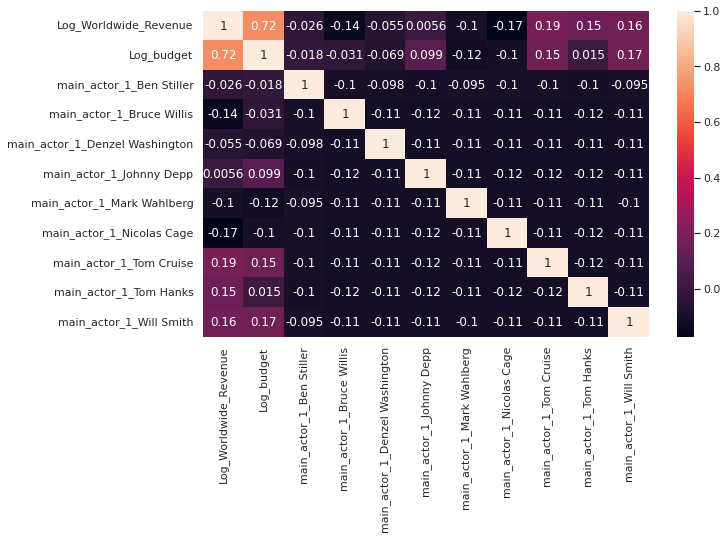

In [505]:
#Relationship between Revenue and TOP 10 Main Actors

corrMatrix_actor = actor_df.corr()
plt.subplots(figsize = (10,6))
sns.heatmap(corrMatrix_actor, annot=True)
plt.show()

## There is a very weak correlation between Main Actor and Worldwide Revenue

In [506]:
x4 = actor_df.drop(['Log_Worldwide_Revenue', 'movie_id'], axis=1)
y4 = actor_df['Log_Worldwide_Revenue']
X4_train, X4_test, y4_train, y4_test = train_test_split(x4,y4, random_state=1, test_size=0.20)
print('Train set: ', X4_train.shape, y4_train.shape)
print('Test set: ', X4_test.shape, y4_test.shape)

Train set:  (188, 10) (188,)
Test set:  (47, 10) (47,)


In [507]:
lm4 = LinearRegression()
lm4.fit(X4_train, y4_train)
lm4_prediction = lm4.predict(X4_test)
#run_time=time.time()
results_12 = {'Model':'Linear Regression','Dependent Var':'Budget & Actor', 'R-Square':metrics.r2_score(y4_test, lm4_prediction), 
            'MSE':metrics.mean_squared_error(y4_test, lm4_prediction),
            'RMSE':np.sqrt(metrics.mean_squared_error(y4_test, lm4_prediction)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_12, ignore_index=True)

In [508]:
model4_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="mse", 
                             min_child_samples=100,
                             use_best_model=True)
model4_lgb.fit(X4_train.values,y4_train)
lgb4_pred_train=model4_lgb.predict(X4_test.values)
#run_time=time.time()
results_13 = {'Model':'LGBMReg','Dependent Var':'Budget & Actor', 'R-Square':metrics.r2_score(y4_test, lgb4_pred_train), 
            'MSE':metrics.mean_squared_error(y4_test, lgb4_pred_train),
            'RMSE':np.sqrt(metrics.mean_squared_error(y4_test, lgb4_pred_train)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_13, ignore_index=True)

In [509]:
rf4_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
rf4_model.fit(X4_train, y4_train)

rf4_model=rf4_model.predict(X4_test.values)
#run_time=time.time()
results_14 = {'Model':'RandomForest','Dependent Var':'Budget & Actor', 'R-Square':metrics.r2_score(y4_test, rf4_model), 
            'MSE':metrics.mean_squared_error(y4_test, rf4_model),
            'RMSE':np.sqrt(metrics.mean_squared_error(y4_test, rf4_model)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_14, ignore_index=True)

####**MPAA**

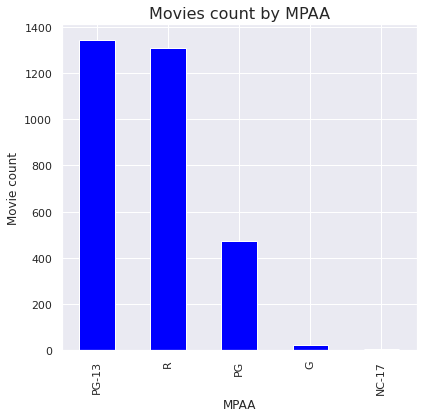

In [510]:
## MPAA
## Checking the movies count per MPAA

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
moviesNew['mpaa'].value_counts().plot(kind='bar', color='blue');
plt.title('Movies count by MPAA', size=16)
plt.xlabel('MPAA', size=12)
plt.ylabel('Movie count', size=12);

## Top movies released was PG-13 rating

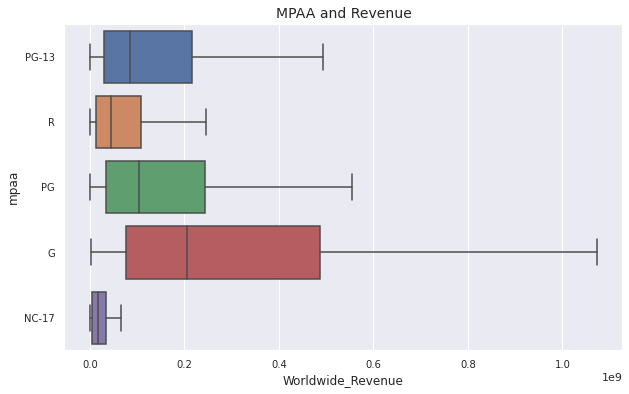

In [511]:
## Looking at MPAA and Revenue

fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', labelsize=10)
plt.title('MPAA and Revenue', fontsize=14)
plt.xlabel('Worldwide Revenue', fontsize=12)
plt.ylabel('MPAA', fontsize=12)
sns.boxplot(ax=ax, x=moviesNew.Worldwide_Revenue, y=moviesNew.mpaa, showfliers=False, orient='h')
plt.show();

## Movies rating G have higer revenue than other ratings

In [512]:
mpaa_df = moviesNew[['movie_id', 'Log_Worldwide_Revenue', 'Log_budget', 'mpaa']]
mpaa_df.head(3)

,movie_id,Log_Worldwide_Revenue,Log_budget,mpaa
0,tt0099088,19.321428,17.504390,PG-13
1,tt0099165,16.568610,17.665658,R
2,tt0099348,19.865736,16.906553,PG-13


In [513]:
## Creating dummys for MPAA

mpaa_df = pd.get_dummies(mpaa_df, columns=['mpaa'], drop_first=True)
mpaa_df.head(3)

,movie_id,Log_Worldwide_Revenue,Log_budget,mpaa_NC-17,mpaa_PG,mpaa_PG-13,mpaa_R
0,tt0099088,19.321428,17.504390,0,0,1,0
1,tt0099165,16.568610,17.665658,0,0,0,1
2,tt0099348,19.865736,16.906553,0,0,1,0


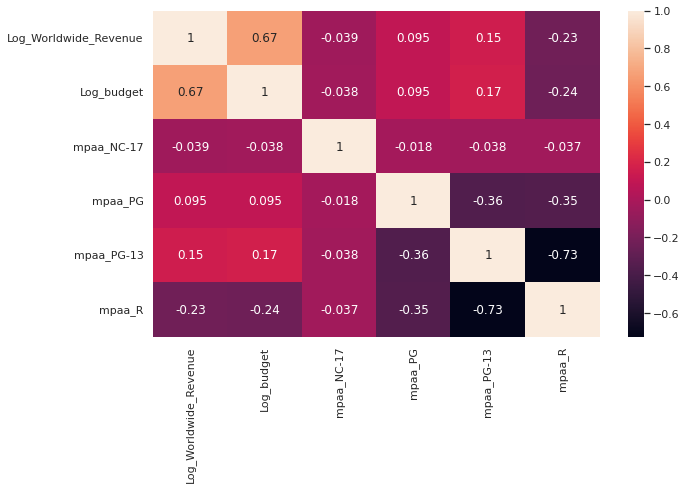

In [514]:
#Relationship between Revenue and MPAA

corrMatrix_mpaa = mpaa_df.corr()
plt.subplots(figsize = (10,6))
sns.heatmap(corrMatrix_mpaa, annot=True)
plt.show()

## There is a very weak correlation between MPAA and Worldwide Revenue

In [515]:
x5 = mpaa_df.drop(['Log_Worldwide_Revenue', 'movie_id'], axis=1)
y5 = mpaa_df['Log_Worldwide_Revenue']
X5_train, X5_test, y5_train, y5_test = train_test_split(x5,y5, random_state=1, test_size=0.20)
print('Train set: ', X5_train.shape, y5_train.shape)
print('Test set: ', X5_test.shape, y5_test.shape)

Train set:  (2520, 5) (2520,)
Test set:  (631, 5) (631,)


In [516]:
lm5 = LinearRegression()
lm5.fit(X5_train, y5_train)
lm5_prediction = lm5.predict(X5_test)
#run_time=time.time()
results_15 = {'Model':'Linear Regression','Dependent Var':'Budget & MPAA', 'R-Square':metrics.r2_score(y5_test, lm5_prediction), 
            'MSE':metrics.mean_squared_error(y5_test, lm5_prediction),
            'RMSE':np.sqrt(metrics.mean_squared_error(y5_test, lm5_prediction)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_15, ignore_index=True)

In [517]:
model5_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="mse", 
                             min_child_samples=100,
                             use_best_model=True)
model5_lgb.fit(X5_train.values,y5_train)
lgb5_pred_train=model5_lgb.predict(X5_test.values)
#run_time=time.time()
results_16 = {'Model':'LGBMReg','Dependent Var':'Budget & MPAA', 'R-Square':metrics.r2_score(y5_test, lgb5_pred_train), 
            'MSE':metrics.mean_squared_error(y5_test, lgb5_pred_train),
            'RMSE':np.sqrt(metrics.mean_squared_error(y5_test, lgb5_pred_train)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_16, ignore_index=True)

In [518]:
rf5_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
rf5_model.fit(X5_train, y5_train)

rf5_model=rf5_model.predict(X5_test.values)
#run_time=time.time()
results_17 = {'Model':'RandomForest','Dependent Var':'Budget & MPAA', 'R-Square':metrics.r2_score(y5_test, rf5_model), 
            'MSE':metrics.mean_squared_error(y5_test, rf5_model),
            'RMSE':np.sqrt(metrics.mean_squared_error(y5_test, rf5_model)), 'Run Time':round(((time.time()-run_time)/60),2)}
results_df = results_df.append(results_17, ignore_index=True)

####**Release Date**

In [519]:
## First, splitting the release_date into Month and Day

moviesNew[["Release_month", "Release_day"]] = moviesNew["release_date"].str.split(" ", expand = True)
moviesNew.head(3)

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,Log_Worldwide_Revenue,Log_budget,Universal Pictures,Warner Bros.,Orion Pictures,Walt Disney Studios Motion Pictures,Twentieth Century Fox,Paramount Pictures,Shapiro-Glickenhaus Entertainment,New Line Cinema,Miramax,Sony Pictures Releasing,TriStar Pictures,Columbia Pictures,The Samuel Goldwyn Company,Metro-Goldwyn-Mayer MGM,Fine Line Features,IRS Media,Orion Classics,Roxie Releasing,Savoy Pictures,Gramercy Pictures I,October Films,Fox Searchlight Pictures,...,Sofia Mali,J. Michael Finley,Linda Hamilton,Haley Lu Richardson,Florence Hartigan,Justin Theroux,Yihong Duan,Michael Ealy,Lucy Hale,Alek Skarlatos,Lupita Nyong'o,Ed Skrein,Angourie Rice,Marcel Ruiz,Gabrielle Union,Sophie Nélisse,Jacob Tremblay,John David Washington,Naomie Harris,Greg Cipes,Mackenzie Davis,Tiffany Haddish,Isabela Merced,Trevor Jackson,Margot Robbie,Dave Bautista,Samara Weaving,Chelsea Peretti,Octavia Spencer,Masako Nozawa,Himesh Patel,Betty Gilpin,Kaya Scodelario,Dean-Charles Chapman,Madison Ingoldsby,Tim Matheson,Florence Pugh,Ashley Bratcher,Release_month,Release_day
0,tt0099088,Back to the Future Part III,1990,PG-13,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,19.321428,17.504390,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,May,25
1,tt0099165,The Bonfire of the Vanities,1990,R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,16.568610,17.665658,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,December,22
2,tt0099348,Dances with Wolves,1990,PG-13,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,424208848.0,Adventure,Drama,19.865736,16.906553,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,November,9


In [520]:
## Combine year, month and day in one Object

moviesNew['releaseDate'] = moviesNew['Release_month'] + '-' + moviesNew['Release_day'] + '-' + moviesNew['year'].astype(str)
moviesNew.drop(['Release_month', 'Release_day'], axis='columns', inplace=True)
moviesNew.head(3)

,movie_id,title,year,mpaa,release_date,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,Log_Worldwide_Revenue,Log_budget,Universal Pictures,Warner Bros.,Orion Pictures,Walt Disney Studios Motion Pictures,Twentieth Century Fox,Paramount Pictures,Shapiro-Glickenhaus Entertainment,New Line Cinema,Miramax,Sony Pictures Releasing,TriStar Pictures,Columbia Pictures,The Samuel Goldwyn Company,Metro-Goldwyn-Mayer MGM,Fine Line Features,IRS Media,Orion Classics,Roxie Releasing,Savoy Pictures,Gramercy Pictures I,October Films,Fox Searchlight Pictures,...,Michelle Dockery,Sofia Mali,J. Michael Finley,Linda Hamilton,Haley Lu Richardson,Florence Hartigan,Justin Theroux,Yihong Duan,Michael Ealy,Lucy Hale,Alek Skarlatos,Lupita Nyong'o,Ed Skrein,Angourie Rice,Marcel Ruiz,Gabrielle Union,Sophie Nélisse,Jacob Tremblay,John David Washington,Naomie Harris,Greg Cipes,Mackenzie Davis,Tiffany Haddish,Isabela Merced,Trevor Jackson,Margot Robbie,Dave Bautista,Samara Weaving,Chelsea Peretti,Octavia Spencer,Masako Nozawa,Himesh Patel,Betty Gilpin,Kaya Scodelario,Dean-Charles Chapman,Madison Ingoldsby,Tim Matheson,Florence Pugh,Ashley Bratcher,releaseDate
0,tt0099088,Back to the Future Part III,1990,PG-13,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,19.321428,17.504390,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,May-25-1990
1,tt0099165,The Bonfire of the Vanities,1990,R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,16.568610,17.665658,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,December-22-1990
2,tt0099348,Dances with Wolves,1990,PG-13,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,424208848.0,Adventure,Drama,19.865736,16.906553,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,November-9-1990


In [521]:
moviesNew.drop(['year', 'release_date'], axis='columns', inplace=True)
moviesNew.head(2)

,movie_id,title,mpaa,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,Log_Worldwide_Revenue,Log_budget,Universal Pictures,Warner Bros.,Orion Pictures,Walt Disney Studios Motion Pictures,Twentieth Century Fox,Paramount Pictures,Shapiro-Glickenhaus Entertainment,New Line Cinema,Miramax,Sony Pictures Releasing,TriStar Pictures,Columbia Pictures,The Samuel Goldwyn Company,Metro-Goldwyn-Mayer MGM,Fine Line Features,IRS Media,Orion Classics,Roxie Releasing,Savoy Pictures,Gramercy Pictures I,October Films,Fox Searchlight Pictures,Sony Pictures Classics,Trimark Pictures,...,Michelle Dockery,Sofia Mali,J. Michael Finley,Linda Hamilton,Haley Lu Richardson,Florence Hartigan,Justin Theroux,Yihong Duan,Michael Ealy,Lucy Hale,Alek Skarlatos,Lupita Nyong'o,Ed Skrein,Angourie Rice,Marcel Ruiz,Gabrielle Union,Sophie Nélisse,Jacob Tremblay,John David Washington,Naomie Harris,Greg Cipes,Mackenzie Davis,Tiffany Haddish,Isabela Merced,Trevor Jackson,Margot Robbie,Dave Bautista,Samara Weaving,Chelsea Peretti,Octavia Spencer,Masako Nozawa,Himesh Patel,Betty Gilpin,Kaya Scodelario,Dean-Charles Chapman,Madison Ingoldsby,Tim Matheson,Florence Pugh,Ashley Bratcher,releaseDate
0,tt0099088,Back to the Future Part III,PG-13,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,19.321428,17.504390,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,May-25-1990
1,tt0099165,The Bonfire of the Vanities,R,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,16.568610,17.665658,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,December-22-1990


In [522]:
## Changing the type of the Release Date

moviesNew['releaseDate'] = pd.to_datetime(moviesNew['releaseDate'], format='%B-%d-%Y')
moviesNew.head(2)

,movie_id,title,mpaa,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,Log_Worldwide_Revenue,Log_budget,Universal Pictures,Warner Bros.,Orion Pictures,Walt Disney Studios Motion Pictures,Twentieth Century Fox,Paramount Pictures,Shapiro-Glickenhaus Entertainment,New Line Cinema,Miramax,Sony Pictures Releasing,TriStar Pictures,Columbia Pictures,The Samuel Goldwyn Company,Metro-Goldwyn-Mayer MGM,Fine Line Features,IRS Media,Orion Classics,Roxie Releasing,Savoy Pictures,Gramercy Pictures I,October Films,Fox Searchlight Pictures,Sony Pictures Classics,Trimark Pictures,...,Michelle Dockery,Sofia Mali,J. Michael Finley,Linda Hamilton,Haley Lu Richardson,Florence Hartigan,Justin Theroux,Yihong Duan,Michael Ealy,Lucy Hale,Alek Skarlatos,Lupita Nyong'o,Ed Skrein,Angourie Rice,Marcel Ruiz,Gabrielle Union,Sophie Nélisse,Jacob Tremblay,John David Washington,Naomie Harris,Greg Cipes,Mackenzie Davis,Tiffany Haddish,Isabela Merced,Trevor Jackson,Margot Robbie,Dave Bautista,Samara Weaving,Chelsea Peretti,Octavia Spencer,Masako Nozawa,Himesh Patel,Betty Gilpin,Kaya Scodelario,Dean-Charles Chapman,Madison Ingoldsby,Tim Matheson,Florence Pugh,Ashley Bratcher,releaseDate
0,tt0099088,Back to the Future Part III,PG-13,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,19.321428,17.504390,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1990-05-25
1,tt0099165,The Bonfire of the Vanities,R,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,16.568610,17.665658,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1990-12-22


In [523]:
moviesNew['releaseDay'] = moviesNew['releaseDate'].dt.day
moviesNew['releaseMth'] = moviesNew['releaseDate'].dt.month
moviesNew['releaseYear'] = moviesNew['releaseDate'].dt.year
moviesNew.head(2)

,movie_id,title,mpaa,run_time,distributor,director,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,Worldwide_Revenue,genre_1,genre_2,Log_Worldwide_Revenue,Log_budget,Universal Pictures,Warner Bros.,Orion Pictures,Walt Disney Studios Motion Pictures,Twentieth Century Fox,Paramount Pictures,Shapiro-Glickenhaus Entertainment,New Line Cinema,Miramax,Sony Pictures Releasing,TriStar Pictures,Columbia Pictures,The Samuel Goldwyn Company,Metro-Goldwyn-Mayer MGM,Fine Line Features,IRS Media,Orion Classics,Roxie Releasing,Savoy Pictures,Gramercy Pictures I,October Films,Fox Searchlight Pictures,Sony Pictures Classics,Trimark Pictures,...,Linda Hamilton,Haley Lu Richardson,Florence Hartigan,Justin Theroux,Yihong Duan,Michael Ealy,Lucy Hale,Alek Skarlatos,Lupita Nyong'o,Ed Skrein,Angourie Rice,Marcel Ruiz,Gabrielle Union,Sophie Nélisse,Jacob Tremblay,John David Washington,Naomie Harris,Greg Cipes,Mackenzie Davis,Tiffany Haddish,Isabela Merced,Trevor Jackson,Margot Robbie,Dave Bautista,Samara Weaving,Chelsea Peretti,Octavia Spencer,Masako Nozawa,Himesh Patel,Betty Gilpin,Kaya Scodelario,Dean-Charles Chapman,Madison Ingoldsby,Tim Matheson,Florence Pugh,Ashley Bratcher,releaseDate,releaseDay,releaseMth,releaseYear
0,tt0099088,Back to the Future Part III,PG-13,1 hr 58 min,Universal Pictures,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,246144250.0,Adventure,Comedy,19.321428,17.504390,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1990-05-25,25,5,1990
1,tt0099165,The Bonfire of the Vanities,R,2 hr 5 min,Warner Bros.,Brian De Palma,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,Comedy,Drama,16.568610,17.665658,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1990-12-22,22,12,1990


Text(0.5, 1.0, 'Release Date Day of the Year')

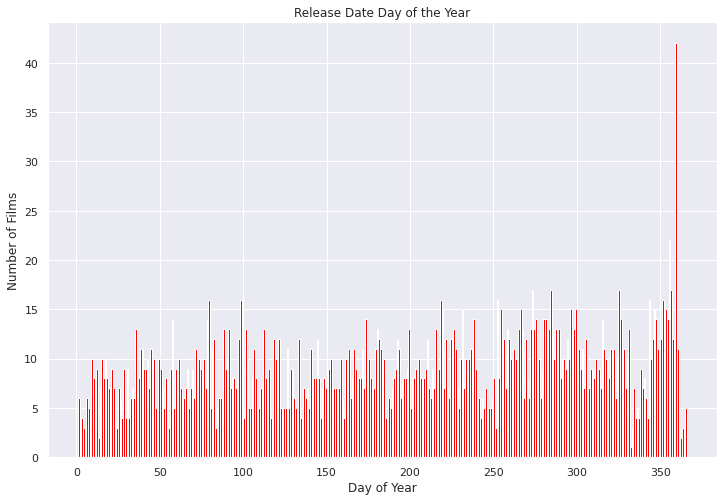

In [524]:
## Plotting Movies release Day of the Year
fig, fx = plt.subplots()
sns.distplot(moviesNew['releaseDate'].dt.dayofyear, bins=365, kde=False, color='red', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,10)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Day of the Year")

## It is a very crowded graph, but it is clear to notice Christmas time has the highest number of movies released.

Text(0.5, 1.0, 'Release Date Week of the Year')

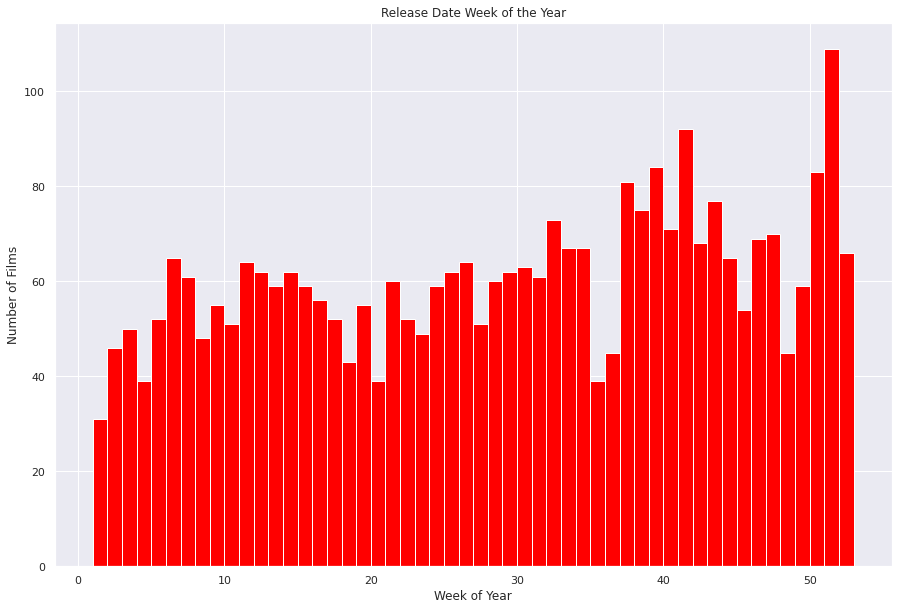

In [525]:
## Plotting Movies release Week of the Year
fig, gx = plt.subplots()
sns.distplot(moviesNew['releaseDate'].dt.weekofyear, bins=52, kde=False, color='red', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,10)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Number of Films")
gx.set_title("Release Date Week of the Year")

## Another graph showing Christmas week has the highest number of movies released due to the popularity of going to the movies during the holiday 
## season. The second largest spike is during the first week of October.

Text(0.5, 1.0, 'Release Date Month of the Year')

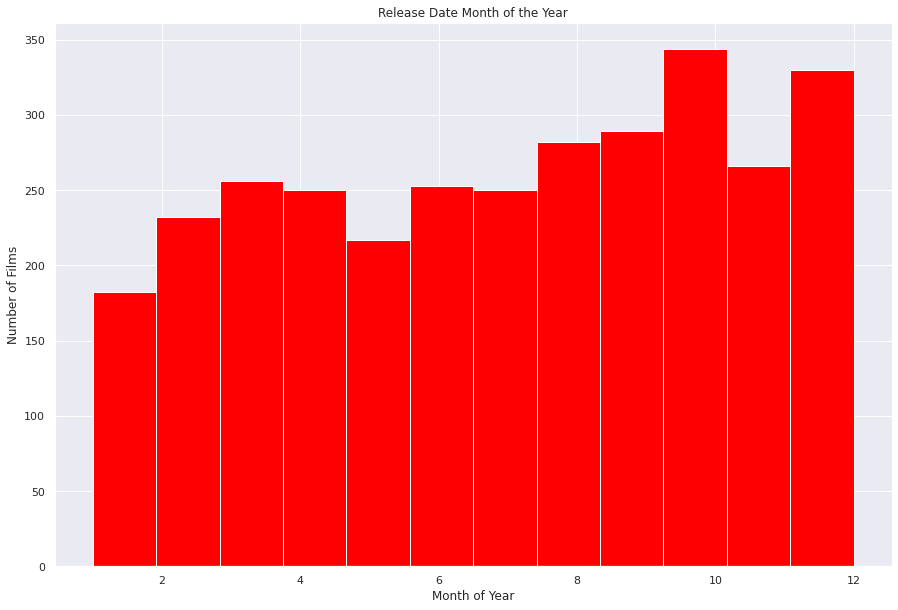

In [526]:
## Plotting Movies release Month of the Year
fig, hx = plt.subplots()
sns.distplot(moviesNew['releaseDate'].dt.month, bins=12, kde=False, color='red', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Number of Films")
hx.set_title("Release Date Month of the Year")

## This graph shows October and December have the highest number of movies released

Text(0.5, 1.0, 'Release Week of the Year by Revenue')

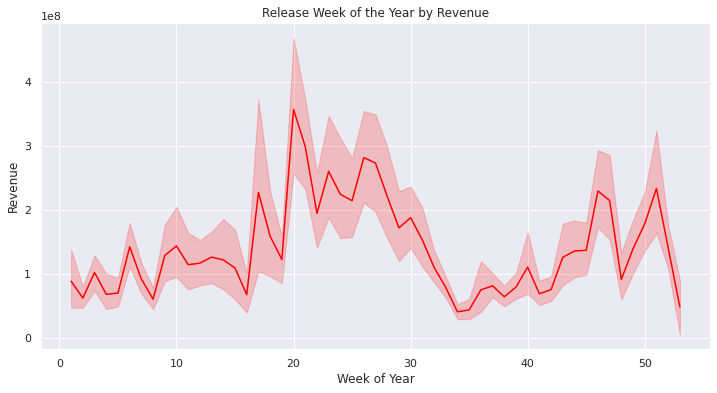

In [527]:
## Week of release with Revenue

fig, fx = plt.subplots()
sns.lineplot(x=moviesNew['releaseDate'].dt.weekofyear, y=moviesNew['Worldwide_Revenue'], color='red')
sns.set(rc={'figure.figsize':(12, 6)})

fx.set_xlabel("Week of Year")
fx.set_ylabel("Revenue")
fx.set_title("Release Week of the Year by Revenue")

## There is a high peak in Revenue during the last week of May and through out the weeks of summer followed by the Christmas week.

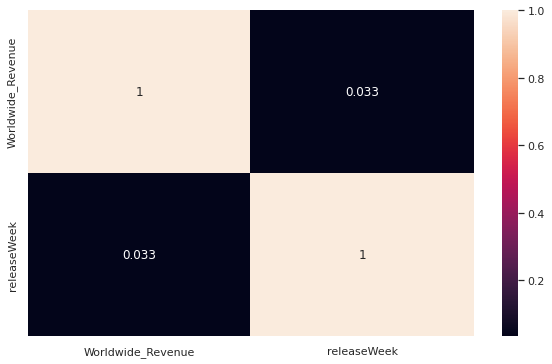

In [528]:
#Relationship between Revenue and Week of Release

moviesNew['releaseWeek'] = moviesNew['releaseDate'].dt.weekofyear
releaseWeek_df = moviesNew[['Worldwide_Revenue', 'releaseWeek']]

corrMatrix_week = releaseWeek_df.corr()
plt.subplots(figsize = (10,6))
sns.heatmap(corrMatrix_week, annot=True)
plt.show()

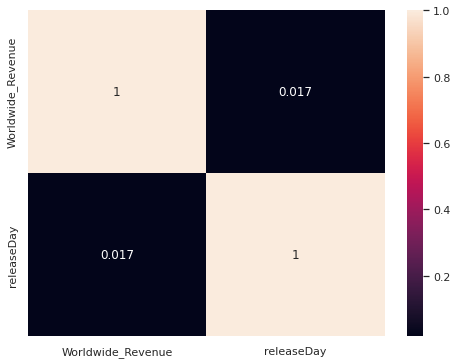

In [529]:
#Relationship between Revenue and Day of Release

releaseDay_df = moviesNew[['Worldwide_Revenue', 'releaseDay']]

corrMatrix_day = releaseDay_df.corr()
plt.subplots(figsize = (8,6))
sns.heatmap(corrMatrix_day, annot=True)
plt.show()

In [530]:
## There is a very little correlation between Released Day, Released Week and Revenue. In summary, the number of movies released in a given month
## or day during the year is not as important as some months that has special events happening, for example, January amd February could be generating 
## more revenue with less movies released because of the Oscar season.

####**SUMMARY & PREDICTION**

In [531]:
results_df = results_df.sort_values(by='R-Square', ascending=False)
results_df.head(5)

,Model,Dependent Var,R-Square,MSE,RMSE,Run Time
3,Linear Regression,Budget & Genre,0.509896,1.576106,1.255431,0.22
5,RandomForest,Budget & Genre,0.500352,1.606799,1.267596,0.28
2,RandomForest,Budget,0.488950,1.505534,1.227002,0.06
15,Linear Regression,Budget & MPAA,0.487490,1.509833,1.228753,0.81
14,RandomForest,Budget & Actor,0.484366,0.616926,0.785446,0.73


In [532]:
## My best model ended up being the Linear Regression model, with Budget and Genre as the 2 dependent varibales. The model scores an RMSE of 1.2554 and 
## the Random Forest model was a second close with RMSE value of 1.2680

In [533]:
## Predictions using Budget and Genre

rev_prediction = np.expm1(lm1.predict(X1_test))
lm1_predict = pd.DataFrame(rev_prediction, columns=['Predicted_Revenue'])
lm1_predict.head(5)

,Predicted_Revenue
0,4.164916e+06
1,2.327033e+07
2,5.753357e+06
3,9.628572e+07
4,2.199198e+08


In [534]:
## Comparing Predicted Revenue and Original Revenue

test_result = pd.concat([moviesNew, lm1_predict], axis = 1, sort=True)

#look at the first 5 values
test_result = test_result[['title','budget', 'releaseYear', 'Worldwide_Revenue', 'Predicted_Revenue']]
test_result.head()

,title,budget,releaseYear,Worldwide_Revenue,Predicted_Revenue
0,Back to the Future Part III,40000000.0,1990.0,246144250.0,4.164916e+06
1,The Bonfire of the Vanities,47000000.0,1990.0,15691192.0,2.327033e+07
2,Dances with Wolves,22000000.0,1990.0,424208848.0,5.753357e+06
3,Dick Tracy,47000000.0,1990.0,162738726.0,9.628572e+07
4,Die Hard 2,70000000.0,1990.0,240247433.0,2.199198e+08


In [535]:
test_result['Revenue_diff'] = test_result['Predicted_Revenue'] - test_result['Worldwide_Revenue']
test_result['Diff_percentage'] = test_result['Revenue_diff'] / test_result['Worldwide_Revenue']
test_result.head(5)

,title,budget,releaseYear,Worldwide_Revenue,Predicted_Revenue,Revenue_diff,Diff_percentage
0,Back to the Future Part III,40000000.0,1990.0,246144250.0,4.164916e+06,-2.419793e+08,-0.983079
1,The Bonfire of the Vanities,47000000.0,1990.0,15691192.0,2.327033e+07,7.579139e+06,0.483019
2,Dances with Wolves,22000000.0,1990.0,424208848.0,5.753357e+06,-4.184555e+08,-0.986437
3,Dick Tracy,47000000.0,1990.0,162738726.0,9.628572e+07,-6.645301e+07,-0.408342
4,Die Hard 2,70000000.0,1990.0,240247433.0,2.199198e+08,-2.032768e+07,-0.084611


In [536]:
test_result.to_csv('submission.csv', index=False)

In [537]:
from statistics import mean
print('Average error of Linear Regression: ${:.2f}'.format(mean(abs(np.expm1(lm1.predict(X1_test)) - np.expm1(y1_test.values)))))

Average error of Linear Regression: $79662817.41


In [538]:
## From the above information, with my best model used for the prediction with accuracy only at 50%, we can see that Revenue is off by an average of $76 million on each 
## prediction.## It is a very significant amount, but if we look at the data on hand, for a blockbuster movies that makes over $800 million in revenue, 
## being off by $76 million is very close and a good starting point for prediction.

In [539]:
print("Intercept:", lm1.intercept_)
print("Coefficients:")
list(zip(x1, lm1.coef_))

Intercept: 1.3556088018606758
Coefficients:


[('Log_budget', 0.9602199620713926),
 ('genre_1_Adventure', 0.21451196826244034),
 ('genre_1_Comedy', -0.137625708091583),
 ('genre_1_Crime', -0.2899168514079639),
 ('genre_1_Drama', -0.25917193020212925)]

In [540]:
## Regression equation:
## Revenue = 1.3556 + (0.9602 * Log_budget) + (0.2145 * Adventure) + (-0.1376 * Comedy) + (-0.2899 * Crime) + (-0.2591 * Drama)
## From the above Multiple Linear Regression equation, I can conclude that for an increase in Budget the Revenue increases by 0.9602, 
## and movies with Genre Adventure increases Revenue by 0.2145 